In [14]:
import pandas as pd
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sns
import gc
import itertools
import random
import math
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import numpy as np
# import ray

sys.path.append('../')

In [3]:

"""
Difference of sets
"""
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

"""
Biased coin flipper
"""
def flip(p):
    return 1 if random.random() < p else 0


class_risk_params = {
    'prevalence': 5*10**(-4),
    'vax_effectiveness': 0.851,
    'sensitivity': 0.6
}

def exists_pos_in_class(frac_vax, N, params = class_risk_params):
    num_vax = np.floor(N*frac_vax)
    num_unvax = N-num_vax

    prev_unvax = params['prevalence']
    prev_vax = prev_unvax * (1-params['vax_effectiveness'])

    p_pos_unvax = prev_unvax * (1-params['sensitivity'])
    p_pos_vax = prev_vax * (1-params['sensitivity'])

    prob_exists_positive = 1 - (1-p_pos_unvax)**num_unvax * (1-p_pos_vax)**num_vax
    prob_one_positive = num_unvax * p_pos_unvax * (1-p_pos_unvax)**(num_unvax-1) * (1-p_pos_vax)**num_vax + \
                      (1-p_pos_unvax)**num_unvax * num_vax * p_pos_vax * (1-p_pos_vax)**(num_vax-1)
    approx_error = prob_exists_positive - prob_one_positive

    return prob_exists_positive, prob_one_positive, approx_error*N

aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    'nominal_breathe_virus_emitted_hourly': 3300, # corresponding to 10^8 copies / mL
    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}

def simulate_class_single_aerosol(room,vax_infected, unvax_infected, time,alpha,masked_status,frac_vax,room_vol,N,pixels_per_foot):
    room = room.reset_index()
    vax_infect_id = random.sample(list(room[room['seating'] == 'V']['index'].values), vax_infected)
    unvax_infect_id = random.sample(list(room[room['seating'] == 'U']['index'].values), unvax_infected)
    infected = room[room['index'].isin(np.append(vax_infect_id,unvax_infect_id))]
    uninfected = room[ (~room['index'].isin(np.append(vax_infect_id,unvax_infect_id))) & \
                      (room['seating'] != 'E')  ]
    if vax_infected == 1:
        source_status = 'V'
    elif unvax_infected == 1:
        source_status = 'U'
    infected_x = infected['x']
    infected_y = infected['y']
    
    aerosol_risk = 0.5*generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, frac_vax, params = aerosol_params)
    #p_exist = exists_pos_in_class(frac_vax, N, params = class_risk_params)[0]
    
    p_infections = []
    for i,row in uninfected.iterrows():
        x = row['x']
        y = row['y']
        v_infect = [x-infected_x,y - infected_y]
        v_vert = [0,10000]
        dot = v_infect[1]*v_vert[1]
        mag1 = 10000
        mag2 = np.sqrt((x-infected_x)**2+(y - infected_y)**2)
        theta =  math.acos(dot/(mag1*mag2))*180/math.pi
        if theta < 90 + alpha:
       
            susceptible_status = row['seating']
            dist = np.sqrt((infected_x-x)**2+(infected_y-y)**2)
            p = updated_distance_to_prob(dist,susceptible_status,source_status,masked_status,time,pixels_per_foot)
            p = max(p,aerosol_risk)
            p_infections.append(p)
        else:
            p_infections.append(aerosol_risk)
            
    return np.sum(p_infections)#*p_exist

def updated_distance_to_prob(d,susceptible_status,source_status,masked_status,time,pixels_per_foot): 
    d = d/pixels_per_foot*0.3048
    susceptible_const = 1
    source_const = 1
    masked_const = 1
    if susceptible_status == 'V':
        susceptible_const = 0.25 # depends on 1 - VE {79% or 64%}
    if source_status == 'V':
        source_const = 0.25 #change .29
    if masked_status == True:
        masked_const = 0.8
    # line below add delta variant multiplier, 2.4
    prob = susceptible_const*(1-np.exp(-1 * source_const* masked_const * 0.0135 *time * (-0.1819*np.log(d)+0.43276)/d))
    prob = float(prob)
    return max(prob,0)

def generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, frac_vax, params = aerosol_params):

    v = params['nominal_breathe_virus_emitted_hourly'] # breathing, speaking, singing
    
    hourly_virus_array = np.array([v/1000, v/100, v/10, v, v*10, v*100, v*1000])

  # variables: source vaccinated? susceptible vaccinated? susceptible masked?
    dose_array = hourly_virus_array * params['inhale_air_rate'] / room_vol
    if masked_status == 1:
        dose_array = dose_array * 0.8
    if vax_infected == 1:
        dose_array = dose_array * 0.25 #change to 0.29
  
    effective_dose_array = dose_array / params['dose_response_constant']

    unvax_susceptible_risk_array = 1 - np.exp(-effective_dose_array)
    # line below replace .25 with 1 - VE
    vax_susceptible_risk_array = 0.25 * unvax_susceptible_risk_array
    
    susceptible_risk_array = unvax_susceptible_risk_array * (1-frac_vax) + vax_susceptible_risk_array * frac_vax

    susceptible_risk = np.dot(susceptible_risk_array, np.array(params['viral_load_distribution']))

    # multiply delta variant multiplier 2.4
    individual_susceptible_risk_over_time = susceptible_risk * time

    return individual_susceptible_risk_over_time

In [11]:
def generate_clumpy_plan(N,p,room, clump_size = 3):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    room = room.drop('UnvaxSpot',axis = 1).reset_index()
    grid = room.copy()
    grid['seating'] = 'E'
    
    if Nunvax > 0:
        clump_size = min(clump_size,Nunvax)
        num_clumps = math.floor(Nunvax/clump_size)
        remainder = Nunvax - num_clumps*clump_size
        clump = 0
        while clump < (num_clumps):
            ind1 = np.random.choice(room['index'].values,replace = False)
            grid['seating'].loc[grid['index'] == ind1] = 'U'
            room = room.drop(ind1, axis = 0)
            x_temp = grid['x'].loc[grid['index'] == ind1].values[0]
            y_temp = grid['y'].loc[grid['index'] == ind1].values[0]  
            temp = room.copy()
            temp['dist_infected'] = ((temp['x'] -x_temp) ** 2 + (temp['y'] - y_temp) ** 2) ** 0.5
            temp = temp.sort_values('dist_infected', ascending = True).head(clump_size-1)
            grid['seating'].loc[grid['index'].isin(temp['index'].values)] = 'U'
            room = room.drop(temp['index'].values, axis = 0)
            clump = clump + 1
        remainder_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],remainder,replace = False)
        grid['seating'].loc[grid['index'].isin(remainder_ind)] = 'U'

    vax_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],Nvax,replace = False) 
    grid['seating'].loc[grid['index'].isin(vax_ind)] = 'V'
    
    return grid

def generate_random_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    room = room.drop('UnvaxSpot',axis = 1)
    grid = room.copy()
    grid = grid.reset_index()
    temp = list(np.append(np.append(np.repeat('V',Nvax),np.repeat('U',Nunvax)),np.repeat('E',len(grid)-Nvax-Nunvax)))
    random.shuffle(temp)
    grid['seating'] = temp
    return grid


# Plot seating plans 

In [107]:
rooms = {}
plans = {}

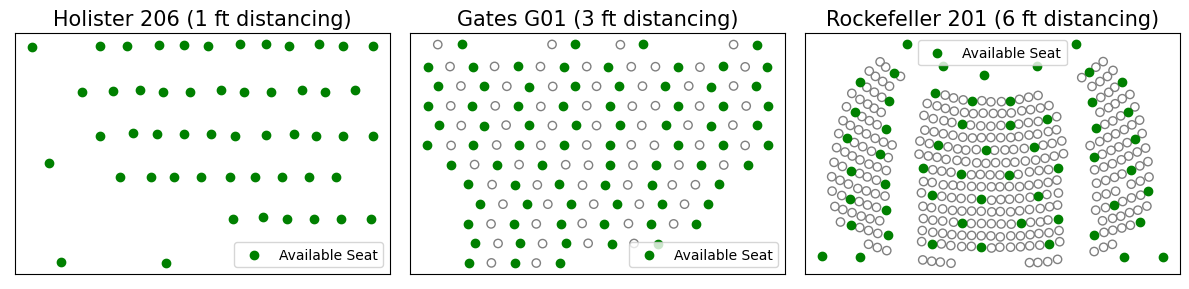

In [110]:
import shapely

fig, axs = plt.subplots(1,3, figsize = (12,3))


for room_idx in range(3):
    if room_idx == 2: # big room
        
        with open("../Data/room_plans/rk201.pickle" , 'rb') as handle:
            layout = pickle.load(handle)

        big_pixels_per_foot = (2074-1575)/20
        big_volume = 1684283

        x_coord = [i.x for i in layout['Middles']]
        y_coord = [i.y for i in layout['Middles']]
        room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
        room['UnvaxSpot'] = layout['In Solution']

        FA2020room = room.copy()
        FA2020room['label'] = FA2020room.index

        #label of seats used in 2020
        indicies = [282,283,284,285, 286,287,288,289,290,365,238,270,273,110,362,358,227,222,260,104,100,348,352,207,20,250,89,
                93,76,80,189,193,172,163,339,334,321,168,25,2,61,65,51,14,121,138,149,308,312,299,294,144,124,34,40,36]
        FA2020room['UnvaxSpot'] = 0
        FA2020room['UnvaxSpot'].iloc[indicies] = 1
        FA2020room.drop('label', axis =1,inplace = True)
        FA2020room['seating'] = 'E'
        FA2020room['seating'].loc[FA2020room['UnvaxSpot'] == 1] = 'U'

        rooms['big'] = FA2020room

        axs[room_idx].scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'], 
                    facecolor = 'none', color = 'grey')
        axs[room_idx].scatter(FA2020room[FA2020room['UnvaxSpot'] == 1]['x'],FA2020room[FA2020room['UnvaxSpot'] == 1]['y'], 
                    label = 'Available Seat', color = 'green')
        axs[room_idx].set_title('Rockefeller 201 (6 ft distancing)', fontsize = 15)
        FA2020_subset = FA2020room[FA2020room['UnvaxSpot']==1 ].reset_index().drop('index', axis = 1)
        big_plan = FA2020_subset.copy()
        axs[room_idx].set_xticks([])
        axs[room_idx].set_yticks([])
        axs[room_idx].legend()
        plans['big'] = big_plan

    if room_idx == 1: # medium room

        with open("../Data/room_plans/gtsg01.pickle" , 'rb') as handle:
            layout = pickle.load(handle)

        medium_pixels_per_foot = (2834-2082)/20
        medium_volume = 1087931

        x_coord = [-i.x +3000 for i in layout['Middles']]
        y_coord = [-i.y +3000 for i in layout['Middles']]
        room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
        room['UnvaxSpot'] = layout['In Solution']
        room_subset = room[room['UnvaxSpot'] == 1].reset_index().drop('index',axis = 1)
        medium_plan = room_subset.copy()

        rooms['medium'] = room

        axs[room_idx].scatter(room[room['UnvaxSpot'] == 0]['x'],room[room['UnvaxSpot'] == 0]['y'],
                    facecolor = 'none', color = 'grey')
        axs[room_idx].scatter(room[room['UnvaxSpot'] == 1]['x'],room[room['UnvaxSpot'] == 1]['y'], 
                    label = 'Available Seat', color = 'green')
        axs[room_idx].set_title('Gates G01 (3 ft distancing)', fontsize = 15)
        axs[room_idx].set_xticks([])
        axs[room_idx].set_yticks([])
        axs[room_idx].legend()
        plans['medium'] = medium_plan
 

    
    if room_idx == 0: # small room

        with open("../Data/room_plans/hls206.pickle" , 'rb') as handle:
            layout = pickle.load(handle)

        small_pixels_per_foot = (2014-1260)/15
        small_volume = 222004

        x_coord = [i.x for i in layout['Middles']]
        y_coord = [i.y for i in layout['Middles']]
        room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
        room['UnvaxSpot'] = layout['In Solution']

        small_plan = room.copy()

        rooms['small'] = small_plan

        axs[room_idx].scatter(small_plan[small_plan['UnvaxSpot'] == 0]['x'],small_plan[small_plan['UnvaxSpot'] == 0]['y'],
                    facecolor = 'none', color = 'grey')
        axs[room_idx].scatter(small_plan[small_plan['UnvaxSpot'] == 1]['x'],small_plan[small_plan['UnvaxSpot'] == 1]['y'], 
                    label = 'Available Seat', color = 'green')
        axs[room_idx].set_title('Holister 206 (1 ft distancing)', fontsize = 15)
        axs[room_idx].set_xticks([])
        axs[room_idx].set_yticks([])
        axs[room_idx].legend()
        plans['small'] = small_plan

plt.tight_layout()
plt.savefig('room_seating_plans.pdf')

# Plot seating assignments

V    35
U    15
E     2
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     6
Name: seating, dtype: int64


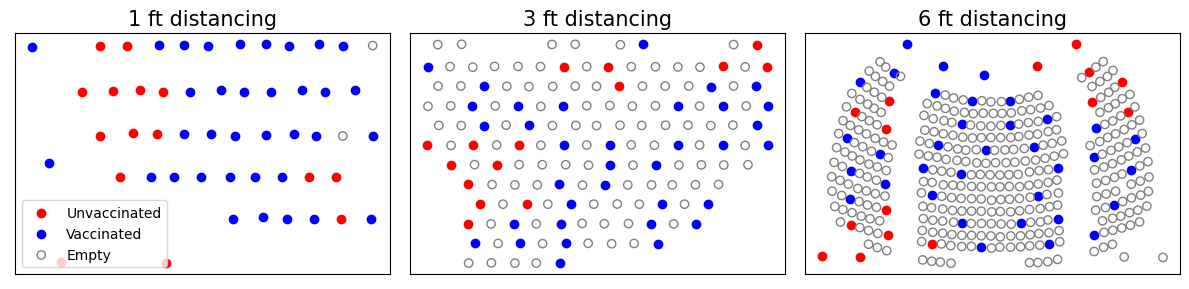

In [127]:
fig, axs = plt.subplots(1,3, figsize = (12,3))

for room_idx in range(3):

    if room_idx == 2: # big room

        grid = generate_clumpy_plan(50,.7,plans['big'],3)
        axs[room_idx].scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], 
                                label = 'Unvax',color = 'red')
        axs[room_idx].scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'],
                                label = 'Vax',color = 'blue')
        axs[room_idx].scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], 
                                color = 'grey', facecolor = 'none')
        big_room = rooms['big']
        axs[room_idx].scatter(big_room[big_room['UnvaxSpot'] == 0]['x'],
                                big_room[big_room['UnvaxSpot'] == 0]['y'],
                                facecolor = 'none', color = 'grey')
        # axs[room_idx].scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
        axs[room_idx].set_title('6 ft distancing', fontsize = 15)
        
        axs[room_idx].set_xticks([])
        axs[room_idx].set_yticks([])
        print(grid['seating'].value_counts())


    if room_idx == 1: # medium room

        grid = generate_clumpy_plan(50,.7,plans['medium'],3)
        axs[room_idx].scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], 
                                label = 'Unvax',color = 'red')
        axs[room_idx].scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], 
                                label = 'Vax',color = 'blue')
        axs[room_idx].scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], 
                                color = 'grey', facecolor = 'none')
        medium_room = rooms['medium']
        axs[room_idx].scatter(medium_room[medium_room['UnvaxSpot'] == 0]['x'],
                                medium_room[medium_room['UnvaxSpot'] == 0]['y'],
                                facecolor = 'none', color = 'grey')
        axs[room_idx].set_title('3 ft distancing', fontsize = 15)
        # axs[room_idx].legend()
        axs[room_idx].set_xticks([])
        axs[room_idx].set_yticks([])
        print(grid['seating'].value_counts())

    if room_idx == 0: # small room

        grid = generate_clumpy_plan(50,.7,plans['small'],3)
        axs[room_idx].scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], 
                                label = 'Unvaccinated',color = 'red')
        axs[room_idx].scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], 
                                label = 'Vaccinated',color = 'blue')
        axs[room_idx].scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], 
                                color = 'grey', facecolor = 'none')
        # small_plan = rooms['small']
        axs[room_idx].scatter(small_plan[small_plan['UnvaxSpot'] == 0]['x'],
                                small_plan[small_plan['UnvaxSpot'] == 0]['y'],
                                facecolor = 'none', color = 'grey', label = 'Empty')
        axs[room_idx].set_title('1 ft distancing', fontsize = 15)
        # axs[room_idx].legend(ncol = 3, bbox_to_anchor = (1.3, 0))
        axs[room_idx].legend(loc = 'best')
        axs[room_idx].set_xticks([])
        axs[room_idx].set_yticks([])
        print(grid['seating'].value_counts())

plt.tight_layout()
plt.savefig('seating_assignments.pdf')

# Plot example simulation tool

V    34
U    15
E     6
Name: seating, dtype: int64


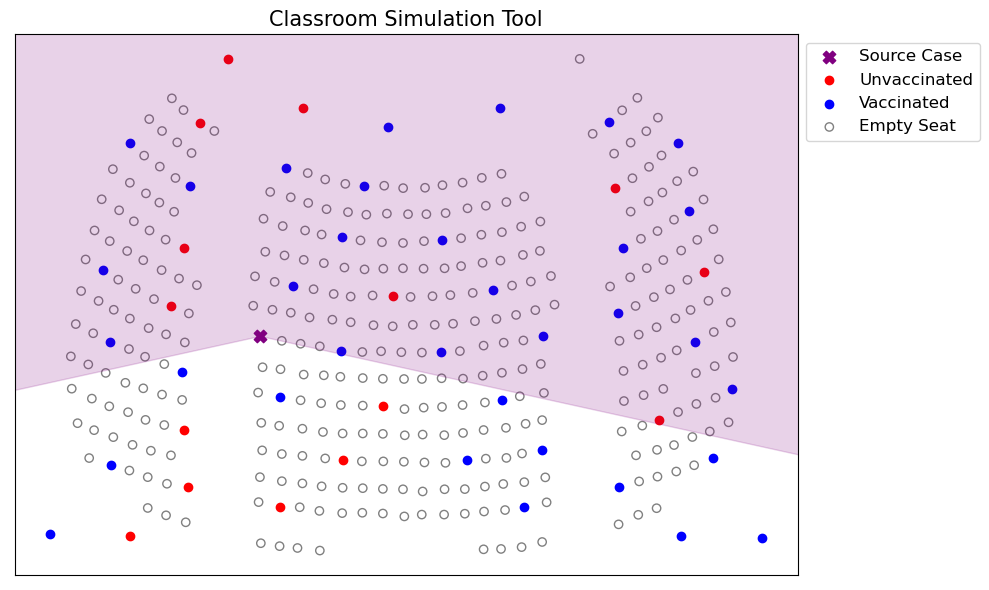

In [129]:
grid = generate_random_plan(50,.7,big_plan)

fig, ax = plt.subplots(figsize = (10,6))

i =25
x = grid.iloc[i]['x']
y = grid.iloc[i]['y']
ax.scatter(x,y, color = 'purple', label = 'Source Case', marker = "X", s = 80)

grid = grid.drop(i)


ax.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'],
            label = 'Unvaccinated',color = 'red')
ax.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'],
            label = 'Vaccinated',color = 'blue')
ax.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], 
            label = 'Empty Seat',color = 'grey', facecolor = 'none')
ax.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],
            color = 'grey', facecolor = 'none')

plt.title('Classroom Simulation Tool', fontsize = 15)

patches = []
wedge = mpatches.Wedge((x, y), 100000000, -15, 180+15, ec="none")
patches.append(wedge)
collection = PatchCollection(patches, color = 'purple', alpha=0.175)
ax.add_collection(collection)

ax.legend(bbox_to_anchor=(1,1), fontsize  = 12)
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())
plt.tight_layout()
plt.savefig('classroom_sim_tool.pdf')

# Plot cone of exposure

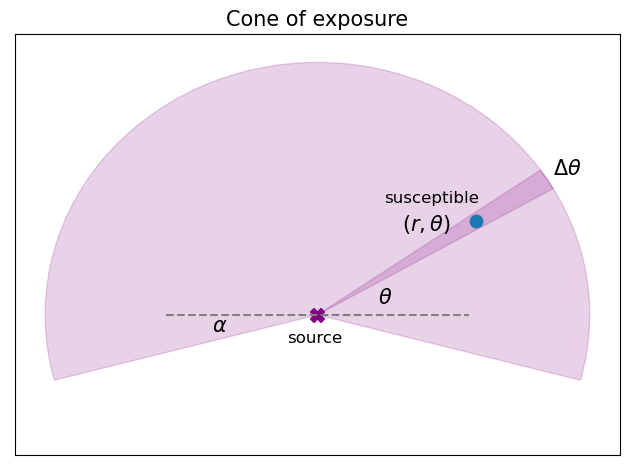

In [230]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import numpy as np

fig, ax = plt.subplots()

patches = []

wedge = mpatches.Wedge((0,0), 0.9, -15, 180+15, ec="none")
wedge2 = mpatches.Wedge((0,0), 0.9, 30, 35, ec="none")
# arc = mpatches.Arc((0,0), 0.1, 0.1, 0, theta2 = 30)

patches.append(wedge)
patches.append(wedge2)
# patches.append(arc)

colors = np.linspace(0, 1, len(patches))
collection = PatchCollection(patches, color = 'purple', alpha=0.175)
# collection.set_array(np.array(colors))
ax.add_collection(collection)

ax.set_xlim([-1,1])
ax.set_ylim([-0.5,1])

ax.scatter(0,0, color = 'purple', label = 'Source Case', marker = "X", s = 100)
ax.scatter(0.525, 0.335, s=80)

ax.hlines(y = 0, xmin = -0.5, xmax = 0.5, color = 'grey', linestyle = '--')
ax.annotate(r'$\alpha$', xy = (-0.35, -0.06), fontsize = 15)
# ax.annotate(r'$\alpha$', xy = (0.3, -0.05))
ax.annotate('source', xy = (-0.1, -0.1), fontsize = 12)
ax.annotate('susceptible', xy = (0.22, 0.4), fontsize = 12)
ax.annotate(r'$(r,\theta)$', xy = (0.28, 0.3), fontsize =15)
ax.annotate(r'$\Delta\theta$', xy = (0.78, 0.5), fontsize = 15)
ax.annotate(r'$\theta$', xy = (0.2, 0.04), fontsize = 15)
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Cone of exposure', fontsize = 15)

plt.tight_layout()
plt.savefig('cone_of_exposure.pdf')

# Below is old

([], [])

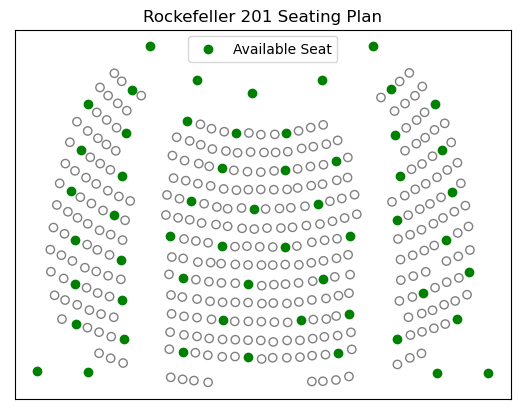

In [38]:
# Big Room
import shapely
with open("../Data/room_plans/rk201.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

big_pixels_per_foot = (2074-1575)/20
big_volume = 1684283


x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']



FA2020room = room.copy()
FA2020room['label'] = FA2020room.index

#label of seats used in 2020
indicies = [282,283,284,285, 286,287,288,289,290,365,238,270,273,110,362,358,227,222,260,104,100,348,352,207,20,250,89,
           93,76,80,189,193,172,163,339,334,321,168,25,2,61,65,51,14,121,138,149,308,312,299,294,144,124,34,40,36]
FA2020room['UnvaxSpot'] = 0
FA2020room['UnvaxSpot'].iloc[indicies] = 1
FA2020room.drop('label', axis =1,inplace = True)
FA2020room['seating'] = 'E'
FA2020room['seating'].loc[FA2020room['UnvaxSpot'] == 1] = 'U'
plt.figure()
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'], 
            facecolor = 'none', color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 1]['x'],FA2020room[FA2020room['UnvaxSpot'] == 1]['y'], 
            label = 'Available Seat', color = 'green')
plt.title('Rockefeller 201 Seating Plan')
FA2020_subset = FA2020room[FA2020room['UnvaxSpot']==1 ].reset_index().drop('index', axis = 1)
big_plan = FA2020_subset.copy()
plt.legend()
plt.xticks([])
plt.yticks([])
#print([big_pixels_per_foot,big_volume,big_plan])

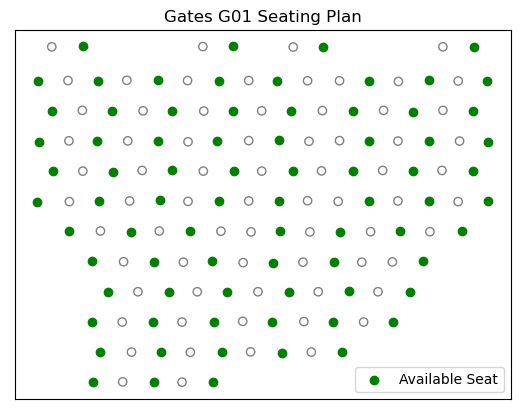

In [39]:
with open("../Data/room_plans/gtsg01.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

medium_pixels_per_foot = (2834-2082)/20
medium_volume = 1087931

x_coord = [-i.x +3000 for i in layout['Middles']]
y_coord = [-i.y +3000 for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']
room_subset = room[room['UnvaxSpot'] == 1].reset_index().drop('index',axis = 1)
medium_plan = room_subset.copy()

plt.scatter(room[room['UnvaxSpot'] == 0]['x'],room[room['UnvaxSpot'] == 0]['y'],
            facecolor = 'none', color = 'grey')
plt.scatter(room[room['UnvaxSpot'] == 1]['x'],room[room['UnvaxSpot'] == 1]['y'], 
            label = 'Available Seat', color = 'green')
plt.title('Gates G01 Seating Plan')
plt.xticks([])
plt.yticks([])
plt.legend()

([], [])

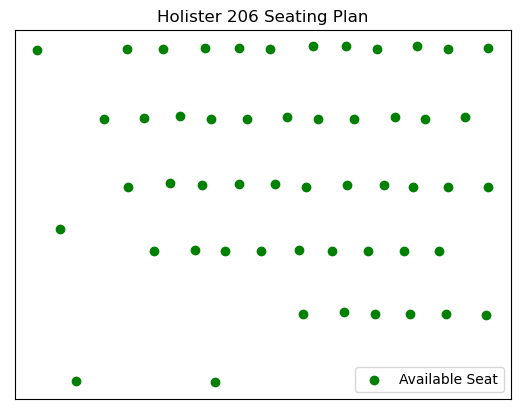

In [40]:
# Small Room
with open("../Data/room_plans/hls206.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

small_pixels_per_foot = (2014-1260)/15
small_volume = 222004

x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']


small_plan = room.copy()


plt.figure()
plt.scatter(small_plan[small_plan['UnvaxSpot'] == 0]['x'],small_plan[small_plan['UnvaxSpot'] == 0]['y'],
            facecolor = 'none', color = 'grey')
plt.scatter(small_plan[small_plan['UnvaxSpot'] == 1]['x'],small_plan[small_plan['UnvaxSpot'] == 1]['y'], 
            label = 'Available Seat', color = 'green')
plt.title('Holister 206 Seating Plan')
plt.legend()
plt.xticks([])
plt.yticks([])

#print([small_pixels_per_foot,small_volume,small_plan])

V    35
U    15
E     6
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     2
Name: seating, dtype: int64


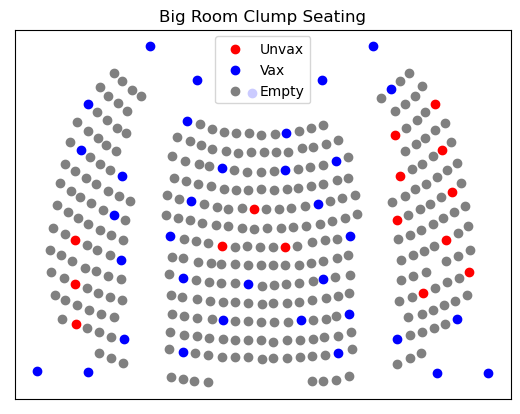

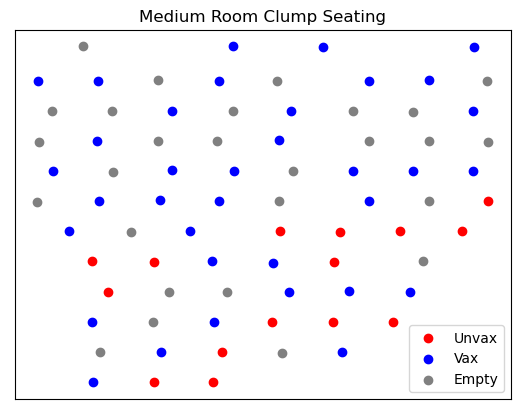

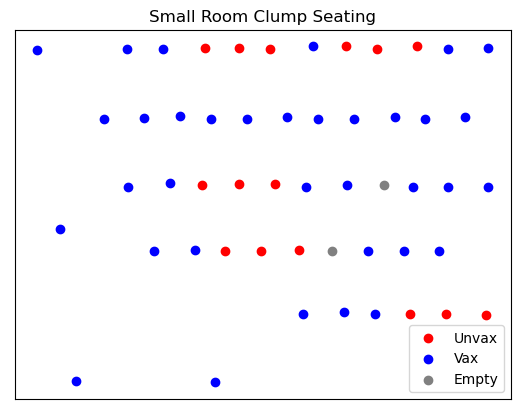

In [34]:
grid = generate_clumpy_plan(50,.7,big_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
plt.title('Big Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_clumpy_plan(50,.7,medium_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Medium Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())


grid = generate_clumpy_plan(50,.7,small_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Small Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

# grid = generate_random_plan(50,.7,big_plan)
# plt.figure()
# plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
# plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
# plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
# plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
# plt.title('Big Room '+ 'Random Seating')
# plt.legend()
# plt.xticks([])
# plt.yticks([])
# print(grid['seating'].value_counts())

# grid = generate_random_plan(50,.7,medium_plan)
# plt.figure()
# plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
# plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
# plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
# plt.title('Medium Room '+ 'Random Seating')
# plt.legend()
# plt.xticks([])
# plt.yticks([])
# print(grid['seating'].value_counts())

# grid = generate_random_plan(50,.7,small_plan)
# plt.figure()
# plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
# plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
# plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
# plt.title('Small Room '+ 'Random Seating')
# plt.legend()
# plt.xticks([])
# plt.yticks([])
# print(grid['seating'].value_counts())

In [94]:
x

774.0091085866338

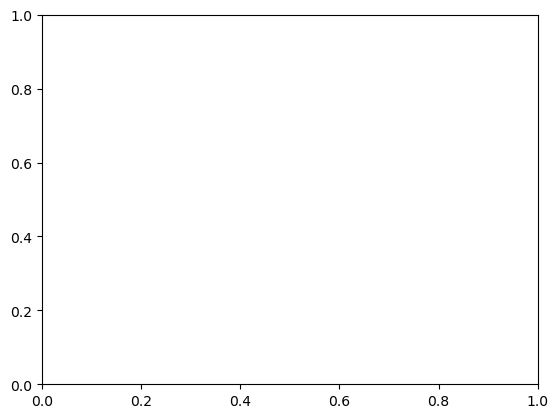

In [132]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import numpy as np

fig, ax = plt.subplots()

patches = []

wedge = mpatches.Wedge((x, y), 0.5, 15, 180-15, ec="none")
patches.append(wedge)

colors = np.linspace(0, 1, len(patches))
collection = PatchCollection(patches, cmap=plt.cm.hsv, alpha=0.3)
collection.set_array(np.array(colors))
ax.add_collection(collection)

plt.show()

In [40]:
grid.iloc[10]

index               10
x           422.071171
y          1447.911411
seating              V
Name: 10, dtype: object

### Simulator

In [ ]:
###Experiment Parameters
masked_status = False
seating_function = generate_random_plan

#Room Parameters
room_vol = small_volume
room = small_plan
pixels_per_foot = small_pixels_per_foot

#General Parameters
p_range = np.arange(0,1.1,.1)
N = 50
time = 1


In [ ]:
@ray.remote
def parallel_wrapper(p):
    trial = 0
    results = []
    while trial < 500:
        grid = seating_function(N,p,room)
        p_generate = p /(4-3*p) # p_generat = (1-VE)*p/(1-VE*p)
        ind = flip(p_generate)
        if sum(grid['seating'] == 'V') == 0:
            ind = 0
        elif sum(grid['seating'] == 'U') == 0:
            ind = 1
        infect = simulate_class_single_aerosol(grid,ind, 1-ind, time,15,masked_status,p,room_vol,N,pixels_per_foot)
        results.append(infect)
        trial = trial + 1
    return [p,np.mean(results),np.std(results)]

In [ ]:
%%time
ray.shutdown()
ray.init()
result_ids = []
for p in p_range:
    result_ids.append(parallel_wrapper.remote(p))    
results = ray.get(result_ids)  
ray.shutdown()
results = pd.DataFrame(results, columns = ['p','mean','std'])

In [2]:
#big_clump_mask = results.copy()
#big_clump_nomask = results.copy()
#big_random_mask = results.copy()
#big_random_nomask = results.copy()

#medium_clump_mask = results.copy()
#medium_clump_nomask = results.copy()
#medium_random_mask = results.copy()
#medium_random_nomask = results.copy()

#small_clump_mask = results.copy()
#small_clump_nomask = results.copy()
#small_random_mask = results.copy()
small_random_nomask = results.copy()

NameError: name 'results' is not defined

In [3]:
results.to_csv('sim_results/small_random_nomask1.csv', index = False)

NameError: name 'results' is not defined

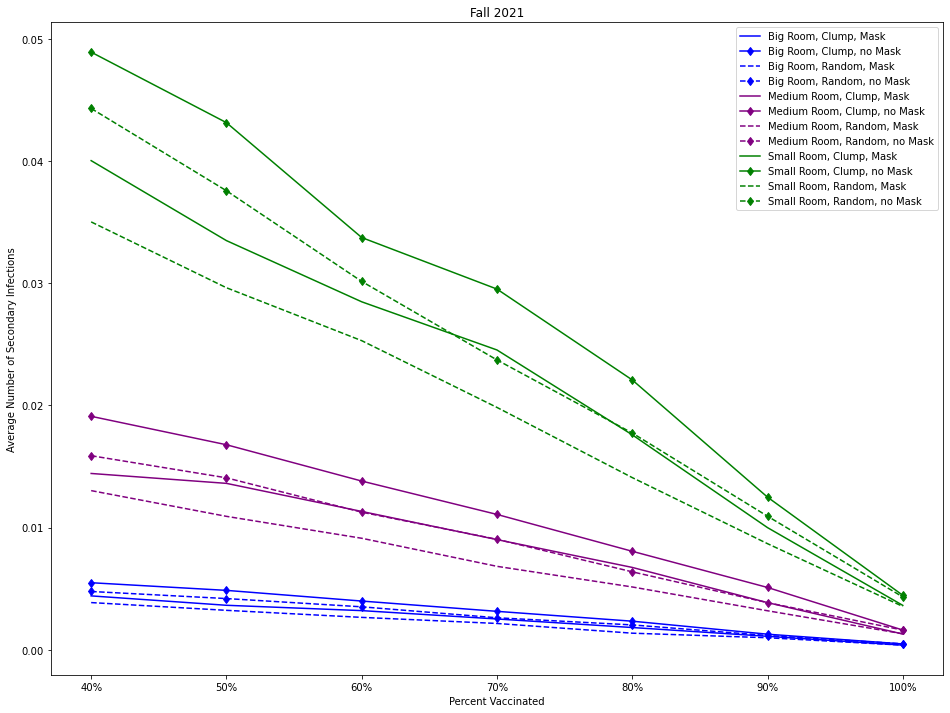

In [83]:
plt.figure(figsize = (16,12))
mark = 'd'
big_clump_mask = big_clump_mask[big_clump_mask['p']>=.4]
big_clump_nomask = big_clump_nomask[big_clump_nomask['p']>=.4]
big_random_mask = big_random_mask[big_random_mask['p']>=.4]
big_random_nomask = big_random_nomask[big_random_nomask['p']>=.4]

medium_clump_mask = medium_clump_mask[medium_clump_mask['p']>=.4]
medium_clump_nomask = medium_clump_nomask[medium_clump_nomask['p']>=.4]
medium_random_mask = medium_random_mask[medium_random_mask['p']>=.4]
medium_random_nomask = medium_random_nomask[medium_random_nomask['p']>=.4]

small_clump_mask = small_clump_mask[small_clump_mask['p']>=.4]
small_clump_nomask = small_clump_nomask[small_clump_nomask['p']>=.4]
small_random_mask = small_random_mask[small_random_mask['p']>=.4]
small_random_nomask = small_random_nomask[small_random_nomask['p']>=.4]

plt.plot(big_clump_mask['p'],big_clump_mask['mean'],label = 'Big Room, Clump, Mask', color = 'blue')
plt.plot(big_clump_nomask['p'],big_clump_nomask['mean'], label = 'Big Room, Clump, no Mask', color = 'blue', marker = mark)
plt.plot(big_random_mask['p'],big_random_mask['mean'],label = 'Big Room, Random, Mask', color = 'blue', linestyle = '--')
plt.plot(big_random_nomask['p'],big_random_nomask['mean'], label = 'Big Room, Random, no Mask', color = 'blue',linestyle = '--', marker = mark)


plt.plot(medium_clump_mask['p'],medium_clump_mask['mean'],label = 'Medium Room, Clump, Mask', color = 'purple')
plt.plot(medium_clump_nomask['p'],medium_clump_nomask['mean'], label = 'Medium Room, Clump, no Mask', color = 'purple',marker = mark)
plt.plot(medium_random_mask['p'],medium_random_mask['mean'],label = 'Medium Room, Random, Mask', color = 'purple' ,linestyle = '--')
plt.plot(medium_random_nomask['p'],medium_random_nomask['mean'], label = 'Medium Room, Random, no Mask', color = 'purple',linestyle = '--' , marker = mark)


plt.plot(small_clump_mask['p'],small_clump_mask['mean'],label = 'Small Room, Clump, Mask', color = 'green')
plt.plot(small_clump_nomask['p'],small_clump_nomask['mean'], label = 'Small Room, Clump, no Mask', color = 'green', marker = mark)
plt.plot(small_random_mask['p'],small_random_mask['mean'],label = 'Small Room, Random, Mask', color = 'green' , linestyle = '--')
plt.plot(small_random_nomask['p'],small_random_nomask['mean'], label = 'Small Room, Random, no Mask', color = 'green',linestyle = '--', marker = mark)


plt.title('Fall 2021')
plt.xlabel('Percent Vaccinated')
plt.xticks(ticks = [.4,.5,.6,.7,.8,.9,1], labels = [ '40%','50%', '60%','70%', '80%','90%','100%'])
#plt.xticks(ticks = [.5,.6,.7,.8,.9,1], labels = [ '50%', '60%','70%', '80%','90%','100%'])
plt.ylabel('Average Number of Secondary Infections')
plt.legend()